# Задача о виртуальной расходометрии скважин

Хакатон по направление Data Scientist от компании "Газпромнефть-Цифровые решения"


![image.png](attachment:image.png)


__Аннотация__

Добро пожаловать Хакатон "Задача о вируальной расходометрии" от компании
"Газпромнефть-Цифровые решения"

Решая это задание, ты узнаешь, из чего состоит работа
начинающего специалиста по данным в области нефтяного инжиниринга.


__Развиваемые навыки и компетенции__

По результатам выполнения заданий ты научишься:
1. Работать с базовой функциональностью библиотек python для анализа данных: pandas, matplotlib, seaborn и т.д.
2. Заполнять пропущенные значения в данных.
3. Анализировать данные и проводить их подготовку.
4. Находодить корреляции между признаками и отбирать данные для прогнозной модели
5. Создавать предсказательную модель и оценивать ее точность.

# Задание

Тебе предстоит изучить данные, содержащие значения измерений различных параметров скважины: дебиты, давления, температура и различные электротехнические параметры

и выполнить __следующие задачи:__

__Задача 0.__ Предложить варианты для заполнения пропущенных данных / предложить варианты по предварительной обработке данных

__Задача 1.__ Проверить эмпирическое правило: чем больше напряжение на ПЭД, тем больше дебит жидкости*

__Задача 2.__ Опираясь на имеющиеся данные, построить модель для предсказания дебита жидкости скважины

* в исходных данных параметр напряжение на ПЭД - столбец "U_AB", а дебит жидкости - "LIQ_RATE"


# О формате решения

Решение __можно представить в виде jupyter notebook__ (ограничений по стеку нет), содержащего решение одной или нескольких задач

Необходимо также подготовить краткую презентацию, в которой будут представлены основные этапы решения и результаты

# Описание задачи

Объект исследования - нефтяная скважина, оборудованная погружным насосом  - УЭЦН (установка электроцентробежного насоса)

Всё оборудование скважины делится на два типа: наземное и подземное

На поверхности имеется возможность провести прямые измерения параметров: дебиты жидкости, давление, температура.

Частота измерений: __редко__ (раз в сутки)

Подземное оборудование представлено погружным насосом, снабженным датчиками телеметрии, которые позволяют измерять давление, температуру и электротехнические параметры насоса.

Частота измерений: __на постоянной основе__

Нефтяная скважина на поверхности выглядит следующим образом:

![image.png](attachment:image.png)

__Дебит жидкости скважины__ - важнейший технологический параметр скважины. Он определяет технологическую и экономическую эффективность работы скважины

Дебит жидкости - отношение количества продукции, протекающий через поперечное сечение трубопровода в единицу времени.

Может измеряться в м3/сут, тонн/сут и т.д.


__Проблема__: Измерение ключевого параметра скважины - дебита жидкости проводятся редко

__Гипотеза__: Имея данные замеров других параметров, можно спрогнозировать соответствующим им дебит жидкости

__Основная цель__: определелить значения дебита жидкости для скважины, используя данные замеров других параметров скважины

![image-2.png](attachment:image-2.png)

# Baseline solution


# Установка библиотек

In [31]:
!pip install numpy
!pip install plotly
!pip install pandas
!pip install scipy
!pip install matplotlib
!pip install sklearn
!pip install seaborn
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached sklearn-0.0.post5.tar.gz (3.7 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package meta

# Импорт библотек

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

from scipy import interpolate
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing, metrics
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Загрузка исходных данных

In [33]:
df = pd.read_csv("sources/data/test_well.csv")
df.head()

,DT_HOUR,EXT_DATA,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PED_T,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,U_OTP,COS_PHI
0,2021-03-21 00:00:00,0,NaN,NaN,NaN,NaN,NaN,NaN,67.925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-03-21 00:19:23,0,NaN,NaN,NaN,16.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-03-21 00:19:26,0,NaN,NaN,NaN,NaN,NaN,40.0,NaN,0.0,37.17,29.5,29.4,29.6,396.0,399.0,399.0,NaN,71.0
3,2021-03-21 00:20:00,0,NaN,NaN,NaN,NaN,NaN,NaN,67.920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-03-21 00:38:32,0,NaN,NaN,NaN,17.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Предварительный анализ данных

Данные представляют из себя перечень замеров параметров одной скважины

По скважине в различные моменты времени представлены замеры дебитов жидкости, нефти, газа, обводненность, линейное давления,  электротехнические
параметры

Целевая переменная - __дебит жидкости__

Необходимо восстановить значения данного параметра, замеры которого находится в столбце с названием "__LIQ_RATE__"

In [34]:
len_df = df.shape[0]

In [35]:
# Определим количество прямых замеров дебита жидкости
count_df_LIQ_RATE = df["LIQ_RATE"].count()
count_df_LIQ_RATE

146

In [36]:
# Проведем анализ имеющихся данных
df.describe()

,EXT_DATA,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PED_T,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,U_OTP,COS_PHI
count,20020.000000,146.000000,146.000000,146.000000,6602.000000,146.000000,6595.000000,6592.000000,6595.0,6595.000000,6596.000000,6596.000000,6595.000000,6595.000000,6595.000000,6595.000000,0.0,6595.000000
mean,0.855245,415.724247,45.484384,88.097397,17.879284,2165.620274,41.782948,77.426187,0.0,36.535782,31.122165,31.111098,31.244458,394.055345,398.266262,397.039121,NaN,72.361183
std,10.060267,40.139969,4.454233,0.174743,0.350247,296.131190,1.701624,5.949151,0.0,0.377892,1.419314,1.416309,1.439096,2.871972,2.894213,2.860467,NaN,2.449727
min,0.000000,0.000000,0.000000,87.460000,10.890000,0.000000,0.000000,56.005000,0.0,35.870000,0.000000,0.000000,0.000000,380.000000,385.000000,384.000000,NaN,0.000000
25%,0.000000,403.240000,44.005000,87.980000,17.720000,2060.252500,41.000000,72.955000,0.0,36.170000,30.300000,30.300000,30.400000,392.000000,397.000000,396.000000,NaN,71.000000
50%,0.000000,413.825000,44.995000,88.100000,17.920000,2211.950000,41.000000,73.748000,0.0,36.680000,30.600000,30.600000,30.700000,394.000000,399.000000,397.000000,NaN,72.000000
75%,0.000000,436.287500,47.880000,88.220000,18.080000,2285.165000,43.000000,83.550000,0.0,36.810000,32.200000,32.200000,32.400000,396.000000,401.000000,399.000000,NaN,73.000000
max,120.000000,463.690000,50.900000,88.540000,19.010000,2642.390000,43.000000,83.900000,0.0,39.220000,32.400000,32.400000,32.500000,401.000000,403.000000,404.000000,NaN,74.000000


Посмотрев на данные и описание, мы можем сказать, что общее кол-во строчек - 20020. Большая часть признаков содержит в 3 раза меньше не пустых значений, чем вся структура DataFrame. 

Пустые значения можно заполнить, растянуть значения на следующий момент времени, но в дальнейшем мы будем проводить агрегацию к суточным значениям, поэтому заполнять пропуки на данном этапе не будем.

In [37]:
# Очистим датафрейм от неинформативных и пустых столбцов
df = df.drop(["EXT_DATA", "PED_T", "U_OTP"], axis=1)

array([[<Axes: title={'center': 'LIQ_RATE'}>,
        <Axes: title={'center': 'OIL_RATE'}>,
        <Axes: title={'center': 'WATER_CUT'}>,
        <Axes: title={'center': 'PLIN'}>],
       [<Axes: title={'center': 'QGAS'}>,
        <Axes: title={'center': 'FREQ_HZ'}>,
        <Axes: title={'center': 'ACTIV_POWER'}>,
        <Axes: title={'center': 'PINP'}>],
       [<Axes: title={'center': 'I_B'}>, <Axes: title={'center': 'I_A'}>,
        <Axes: title={'center': 'I_C'}>,
        <Axes: title={'center': 'U_AB'}>],
       [<Axes: title={'center': 'U_BC'}>,
        <Axes: title={'center': 'U_CA'}>,
        <Axes: title={'center': 'COS_PHI'}>, <Axes: >]], dtype=object)

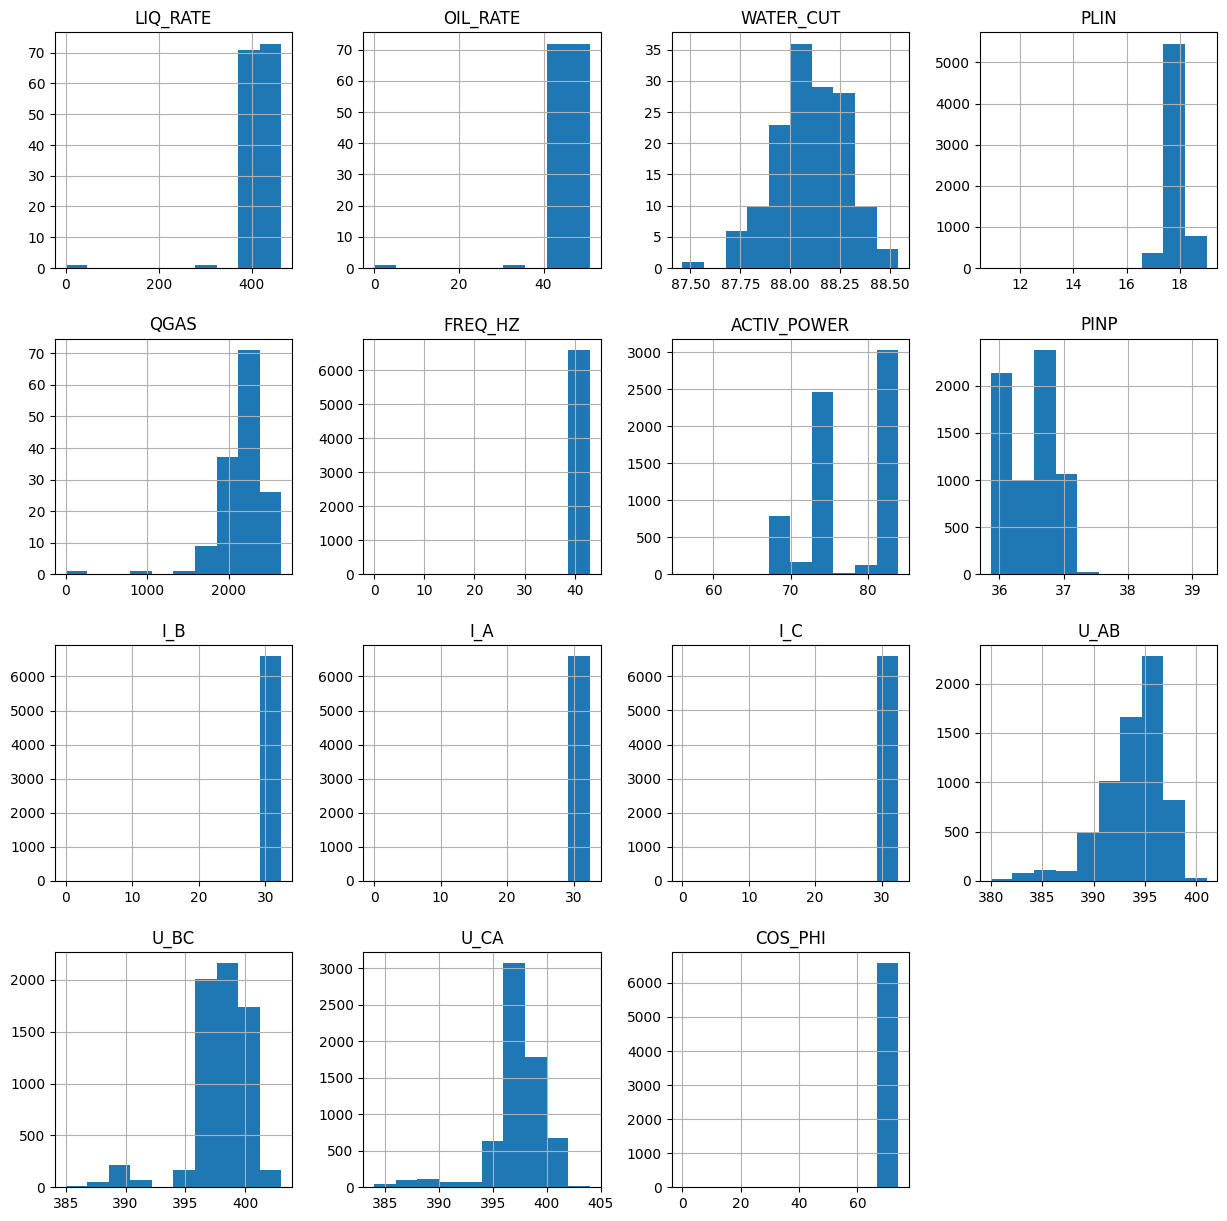

In [38]:
# Построим гистограммы распределения имеющихся данных
df.hist(figsize=(15, 15))

Выше приведены гистограммы, где мы можем наблюдать выбросы для некоторых переменных. 

Например, для стобца признака FREQ_HZ применим "ящик с усами". 

<Axes: >

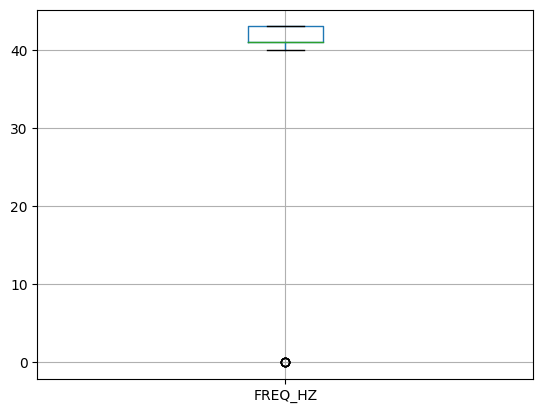

In [39]:
df.boxplot(column="FREQ_HZ")

<Axes: >

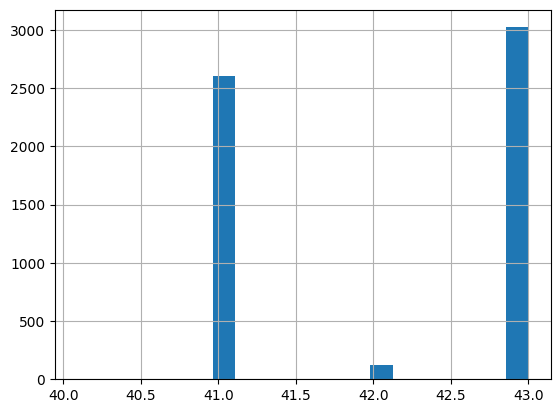

In [40]:
df[df.FREQ_HZ>40].FREQ_HZ.hist(bins=20)

Мы видим, что в нуле есть выброс, а основные значения хранятся в диапазоне, большем 40.

Уберём выбросы у следующих признаков: PLIN, FREQ_HZ, OIL_RATE, U_BC, QGAS.

In [41]:
df=df[((df.PLIN>16.5)|(df.PLIN.isna()))&
 ((df.FREQ_HZ>0)|(df.FREQ_HZ.isna()))&
  ((df.U_BC>393)|(df.U_BC.isna()))&
  ((df.OIL_RATE>40)|(df.OIL_RATE.isna()))&
  ((df.QGAS>1700)|(df.QGAS.isna()))]

array([[<Axes: title={'center': 'LIQ_RATE'}>,
        <Axes: title={'center': 'OIL_RATE'}>,
        <Axes: title={'center': 'WATER_CUT'}>,
        <Axes: title={'center': 'PLIN'}>],
       [<Axes: title={'center': 'QGAS'}>,
        <Axes: title={'center': 'FREQ_HZ'}>,
        <Axes: title={'center': 'ACTIV_POWER'}>,
        <Axes: title={'center': 'PINP'}>],
       [<Axes: title={'center': 'I_B'}>, <Axes: title={'center': 'I_A'}>,
        <Axes: title={'center': 'I_C'}>,
        <Axes: title={'center': 'U_AB'}>],
       [<Axes: title={'center': 'U_BC'}>,
        <Axes: title={'center': 'U_CA'}>,
        <Axes: title={'center': 'COS_PHI'}>, <Axes: >]], dtype=object)

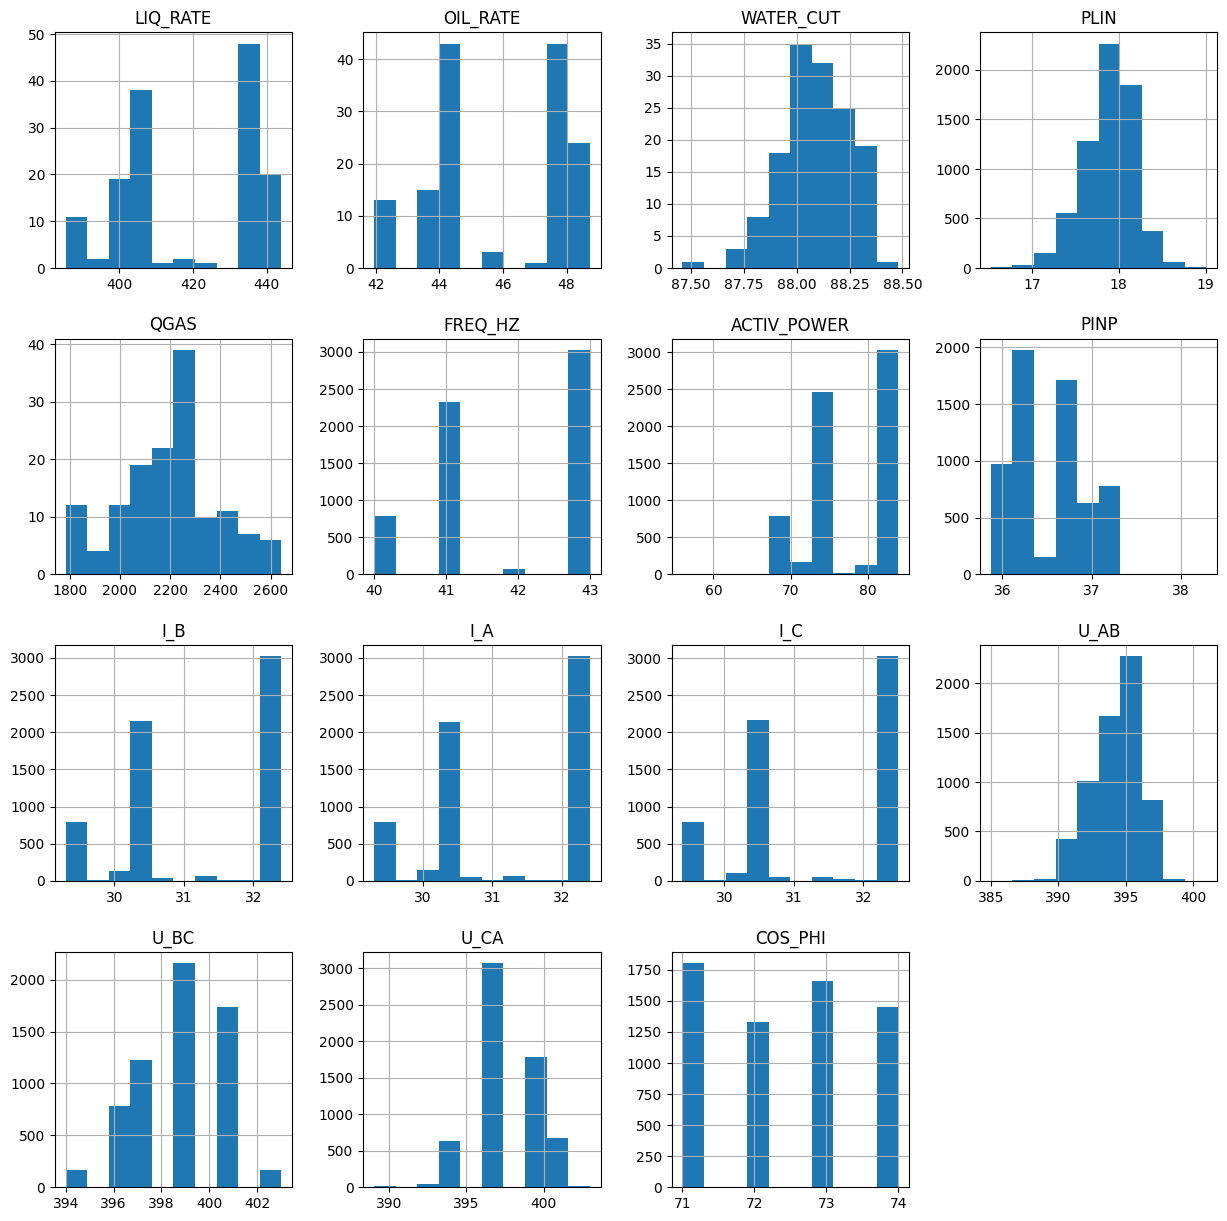

In [42]:
# Построим новую гистограмму

df.hist(figsize=(15, 15))

In [43]:
# Посмотрим, сколько данных мы исключили в этой фильтрации.

1 - df.shape[0]/len_df

0.018581418581418596

In [44]:
# Посмотрим, сколько целевого признака мы исключили после фильтрации.

1 - df.LIQ_RATE.count()/count_df_LIQ_RATE

0.0273972602739726

In [45]:
# Рассчитаем коэффициенты корреляции для имеющихся пар признаков
df.corr()

,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,COS_PHI
LIQ_RATE,1.000000,0.997658,0.034191,NaN,0.792010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OIL_RATE,0.997658,1.000000,0.032638,NaN,0.789070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WATER_CUT,0.034191,0.032638,1.000000,NaN,0.071735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PLIN,NaN,NaN,NaN,1.00000,NaN,NaN,-0.295260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
QGAS,0.792010,0.789070,0.071735,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FREQ_HZ,NaN,NaN,NaN,NaN,NaN,1.000000,0.999951,-0.970956,0.998007,0.997916,0.997908,-0.581940,-0.628378,-0.603054,0.908559
ACTIV_POWER,NaN,NaN,NaN,-0.29526,NaN,0.999951,1.000000,-0.982436,0.996465,0.986880,0.990603,-0.425663,-0.545837,NaN,0.734255
PINP,NaN,NaN,NaN,NaN,NaN,-0.970956,-0.982436,1.000000,-0.970155,-0.969524,-0.969874,0.596399,0.634217,0.607497,-0.861523
I_B,NaN,NaN,NaN,NaN,NaN,0.998007,0.996465,-0.970155,1.000000,0.997416,0.997318,-0.583628,-0.631422,-0.603380,0.905910
I_A,NaN,NaN,NaN,NaN,NaN,0.997916,0.986880,-0.969524,0.997416,1.000000,0.997368,-0.583555,-0.630845,-0.602737,0.906222


<Axes: >

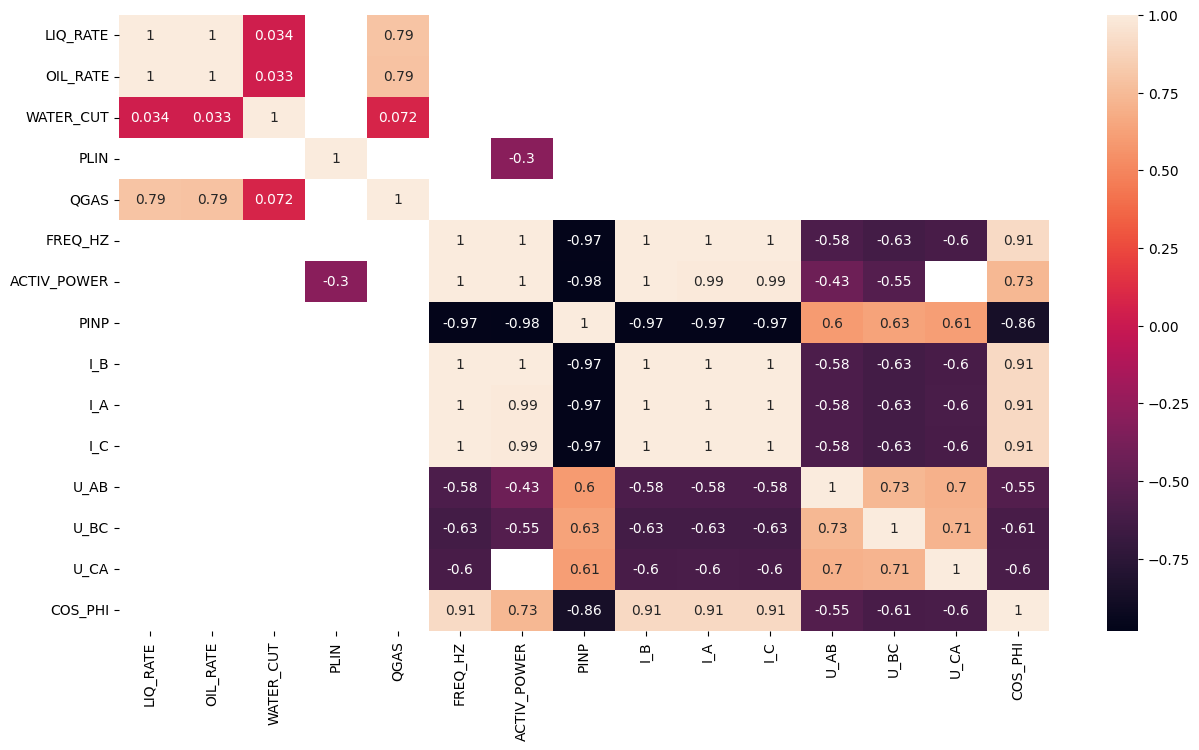

In [46]:
# Представим результат в графическом виде
plt.figure(figsize = (15,8))
sns.heatmap(df.corr(), annot=True, fmt=".2g")

# Подготовка данных

In [47]:
# Преобразование столбца DT_HOUR к типу datetime
df["DT_HOUR"] = pd.to_datetime(df['DT_HOUR'], format='%Y-%m-%dT')
df

,DT_HOUR,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,COS_PHI
0,2021-03-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,67.925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-03-21 00:19:23,NaN,NaN,NaN,16.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-03-21 00:19:26,NaN,NaN,NaN,NaN,NaN,40.0,NaN,37.17,29.5,29.4,29.6,396.0,399.0,399.0,71.0
3,2021-03-21 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,67.920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-03-21 00:38:32,NaN,NaN,NaN,17.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20015,2021-06-20 23:39:18,NaN,NaN,NaN,NaN,NaN,43.0,NaN,36.02,32.2,32.2,32.4,394.0,397.0,397.0,74.0
20016,2021-06-20 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN,83.540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20017,2021-06-20 23:59:47,NaN,NaN,NaN,18.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20018,2021-06-20 23:59:49,NaN,NaN,NaN,NaN,NaN,43.0,NaN,36.03,32.2,32.3,32.3,394.0,399.0,397.0,74.0


In [48]:
# Отсавляем в каждом замере только дату
df["date"] = df['DT_HOUR'].apply(lambda x: x.strftime('%Y-%m-%d'))
df

,DT_HOUR,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,COS_PHI,date
0,2021-03-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,67.925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-21
1,2021-03-21 00:19:23,NaN,NaN,NaN,16.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-21
2,2021-03-21 00:19:26,NaN,NaN,NaN,NaN,NaN,40.0,NaN,37.17,29.5,29.4,29.6,396.0,399.0,399.0,71.0,2021-03-21
3,2021-03-21 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,67.920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-21
4,2021-03-21 00:38:32,NaN,NaN,NaN,17.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20015,2021-06-20 23:39:18,NaN,NaN,NaN,NaN,NaN,43.0,NaN,36.02,32.2,32.2,32.4,394.0,397.0,397.0,74.0,2021-06-20
20016,2021-06-20 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN,83.540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-20
20017,2021-06-20 23:59:47,NaN,NaN,NaN,18.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-20
20018,2021-06-20 23:59:49,NaN,NaN,NaN,NaN,NaN,43.0,NaN,36.03,32.2,32.3,32.3,394.0,399.0,397.0,74.0,2021-06-20


In [49]:
# Группируем по дням показатели замеров и находим среднее значение для каждого дня
df = df.groupby("date").agg("mean")
df

,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,COS_PHI
date,,,,,,,,,,,,,,,
2021-03-21,388.84,42.61,87.46,17.755278,1853.77,40.0,68.041444,37.168472,29.459722,29.461111,29.552778,395.416667,398.861111,398.958333,71.000000
2021-03-22,390.57,42.59,88.04,17.674028,1809.27,40.0,68.106472,37.155556,29.462500,29.463889,29.563889,393.916667,399.166667,397.638889,71.000000
2021-03-23,395.10,42.47,87.95,17.800694,1822.53,40.0,68.024792,37.147778,29.445833,29.441667,29.537500,395.486111,400.666667,398.083333,71.000000
2021-03-24,389.34,42.54,88.02,17.786528,1855.33,40.0,68.118278,37.144306,29.451389,29.444444,29.534722,395.138889,400.083333,397.805556,71.000000
2021-03-25,391.28,42.55,88.22,17.830278,1827.74,40.0,68.120028,37.135000,29.454167,29.445833,29.550000,396.805556,399.916667,398.111111,71.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-16,435.36,47.78,88.12,17.784167,2247.43,43.0,83.571292,36.037500,32.233333,32.198611,32.381944,394.777778,398.430556,396.736111,73.000000
2021-06-17,NaN,NaN,NaN,17.896250,NaN,43.0,83.633875,36.036111,32.219444,32.194444,32.362500,392.361111,396.583333,395.194444,73.000000
2021-06-18,433.74,47.62,88.32,17.996143,2166.77,43.0,83.449194,36.037361,32.212500,32.205556,32.355556,391.611111,396.388889,395.000000,73.000000


In [50]:
df = df.dropna(subset=['LIQ_RATE'])
df

,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,COS_PHI
date,,,,,,,,,,,,,,,
2021-03-21,388.840000,42.61,87.46,17.755278,1853.77,40.0,68.041444,37.168472,29.459722,29.461111,29.552778,395.416667,398.861111,398.958333,71.000000
2021-03-22,390.570000,42.59,88.04,17.674028,1809.27,40.0,68.106472,37.155556,29.462500,29.463889,29.563889,393.916667,399.166667,397.638889,71.000000
2021-03-23,395.100000,42.47,87.95,17.800694,1822.53,40.0,68.024792,37.147778,29.445833,29.441667,29.537500,395.486111,400.666667,398.083333,71.000000
2021-03-24,389.340000,42.54,88.02,17.786528,1855.33,40.0,68.118278,37.144306,29.451389,29.444444,29.534722,395.138889,400.083333,397.805556,71.000000
2021-03-25,391.280000,42.55,88.22,17.830278,1827.74,40.0,68.120028,37.135000,29.454167,29.445833,29.550000,396.805556,399.916667,398.111111,71.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-15,434.676667,47.70,88.25,17.941528,2239.80,43.0,83.748500,36.050278,32.226389,32.206944,32.386111,392.416667,396.875000,396.041667,73.444444
2021-06-16,435.360000,47.78,88.12,17.784167,2247.43,43.0,83.571292,36.037500,32.233333,32.198611,32.381944,394.777778,398.430556,396.736111,73.000000
2021-06-18,433.740000,47.62,88.32,17.996143,2166.77,43.0,83.449194,36.037361,32.212500,32.205556,32.355556,391.611111,396.388889,395.000000,73.000000


In [51]:
df.corr()

,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,COS_PHI
LIQ_RATE,1.000000,0.997731,0.131052,0.136678,0.834960,0.992268,0.992851,-0.959803,0.990417,0.990087,0.990406,-0.543000,-0.614353,-0.554547,0.915868
OIL_RATE,0.997731,1.000000,0.123541,0.130173,0.830905,0.993719,0.994533,-0.963264,0.992421,0.992126,0.992372,-0.555678,-0.628695,-0.567051,0.916787
WATER_CUT,0.131052,0.123541,1.000000,0.151500,0.169518,0.144815,0.140847,-0.139791,0.143806,0.145114,0.145563,-0.189217,-0.139682,-0.216310,0.186525
PLIN,0.136678,0.130173,0.151500,1.000000,0.196480,0.139573,0.131019,-0.142074,0.119166,0.115978,0.117059,0.111857,0.138289,0.154820,0.141454
QGAS,0.834960,0.830905,0.169518,0.196480,1.000000,0.828915,0.824083,-0.750892,0.821718,0.820724,0.820049,-0.337231,-0.369944,-0.347775,0.756997
FREQ_HZ,0.992268,0.993719,0.144815,0.139573,0.828915,1.000000,0.998947,-0.979608,0.999022,0.998886,0.998979,-0.580026,-0.644182,-0.583508,0.912688
ACTIV_POWER,0.992851,0.994533,0.140847,0.131019,0.824083,0.998947,1.000000,-0.980656,0.998915,0.998634,0.998839,-0.576403,-0.643234,-0.579391,0.911511
PINP,-0.959803,-0.963264,-0.139791,-0.142074,-0.750892,-0.979608,-0.980656,1.000000,-0.979758,-0.979087,-0.979535,0.606610,0.666100,0.601195,-0.875672
I_B,0.990417,0.992421,0.143806,0.119166,0.821718,0.999022,0.998915,-0.979758,1.000000,0.999933,0.999949,-0.593330,-0.659545,-0.595132,0.911491
I_A,0.990087,0.992126,0.145114,0.115978,0.820724,0.998886,0.998634,-0.979087,0.999933,1.000000,0.999944,-0.595319,-0.661873,-0.597015,0.912092


<Axes: >

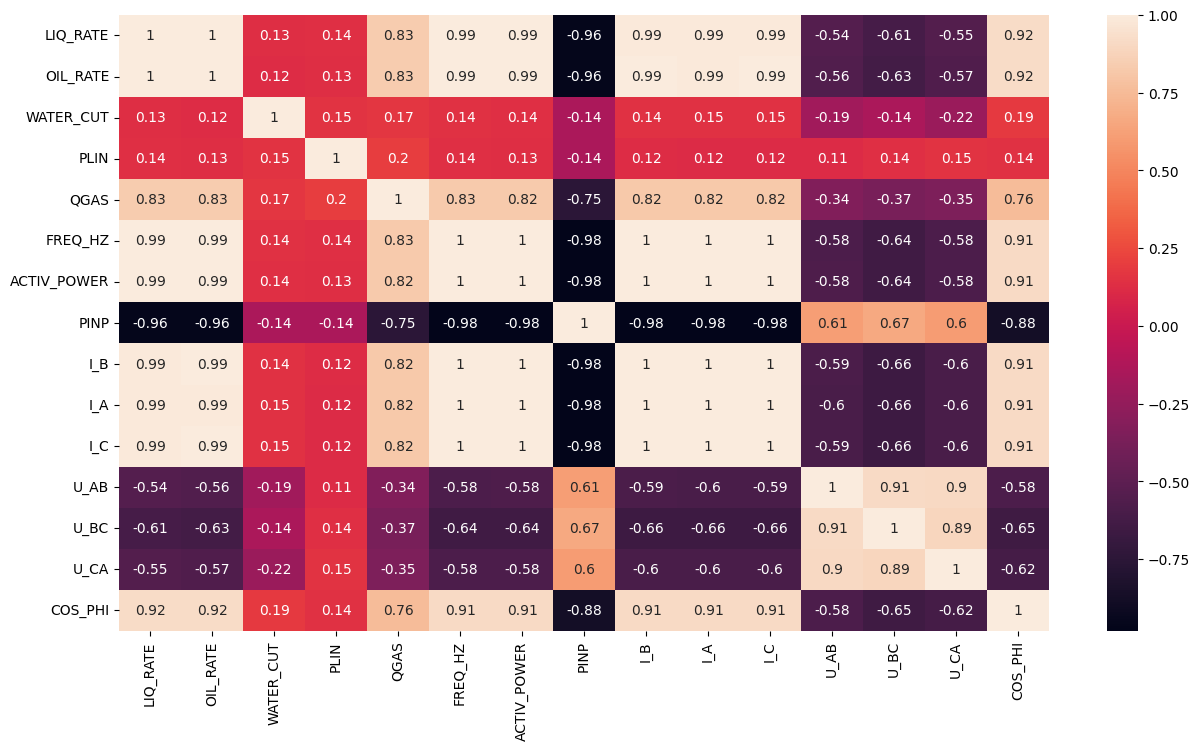

In [52]:
# Представим результат в графическом виде
plt.figure(figsize = (15,8))
sns.heatmap(df.corr(), annot=True, fmt=".2g")

# Проверим эмпирическое правило, что чем больше напряжение на ПЭД, тем больше дебит жидкости

<Axes: xlabel='U_CA', ylabel='LIQ_RATE'>

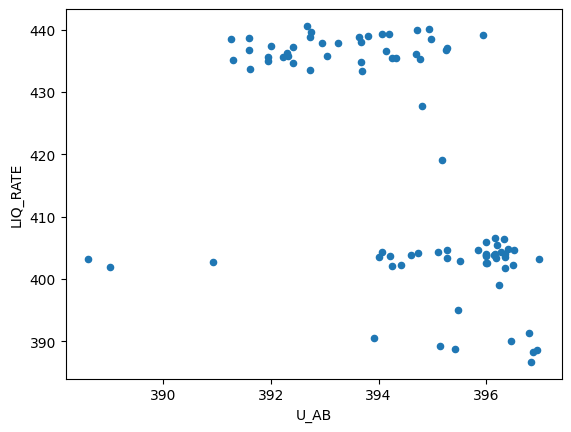

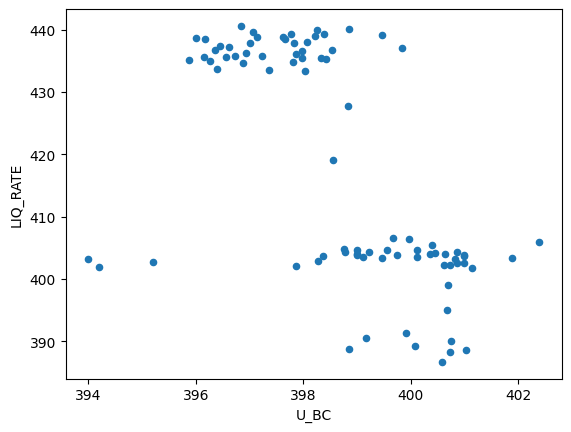

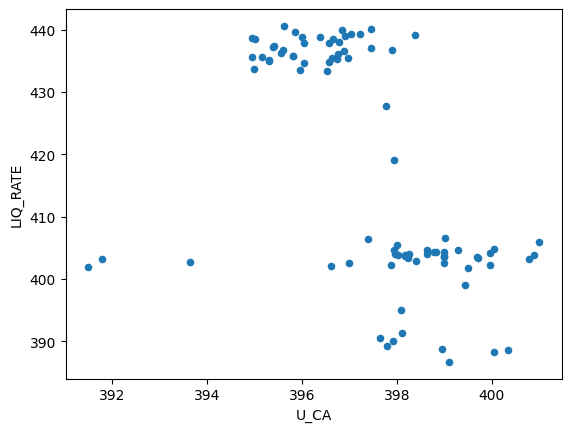

In [53]:
# Построим точечный график

df.plot.scatter(x='U_AB', y='LIQ_RATE')
df.plot.scatter(x='U_BC', y='LIQ_RATE')
df.plot.scatter(x='U_CA', y='LIQ_RATE')

После просмтра распределения LIQ_RATE и U_AB, U_BC, U_CA мы можем сказать, что нет явной зависимости. 

Мы можем выделить два состояния, в каждом из которых, изменения напряжений не ведут к существенному изменению LIQ_RATE. При этом в состоянии с более высокими напряжениями значения показателя LIQ_RATE ниже.

# Построение модели линейной регрессии

In [54]:
# Отбираем фичи для построения модели
# df = df[["LIQ_RATE", "ACTIV_POWER", "PINP"]]
df = df.dropna()
df

,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,COS_PHI
date,,,,,,,,,,,,,,,
2021-03-21,388.840000,42.61,87.46,17.755278,1853.77,40.0,68.041444,37.168472,29.459722,29.461111,29.552778,395.416667,398.861111,398.958333,71.000000
2021-03-22,390.570000,42.59,88.04,17.674028,1809.27,40.0,68.106472,37.155556,29.462500,29.463889,29.563889,393.916667,399.166667,397.638889,71.000000
2021-03-23,395.100000,42.47,87.95,17.800694,1822.53,40.0,68.024792,37.147778,29.445833,29.441667,29.537500,395.486111,400.666667,398.083333,71.000000
2021-03-24,389.340000,42.54,88.02,17.786528,1855.33,40.0,68.118278,37.144306,29.451389,29.444444,29.534722,395.138889,400.083333,397.805556,71.000000
2021-03-25,391.280000,42.55,88.22,17.830278,1827.74,40.0,68.120028,37.135000,29.454167,29.445833,29.550000,396.805556,399.916667,398.111111,71.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-15,434.676667,47.70,88.25,17.941528,2239.80,43.0,83.748500,36.050278,32.226389,32.206944,32.386111,392.416667,396.875000,396.041667,73.444444
2021-06-16,435.360000,47.78,88.12,17.784167,2247.43,43.0,83.571292,36.037500,32.233333,32.198611,32.381944,394.777778,398.430556,396.736111,73.000000
2021-06-18,433.740000,47.62,88.32,17.996143,2166.77,43.0,83.449194,36.037361,32.212500,32.205556,32.355556,391.611111,396.388889,395.000000,73.000000


In [55]:
X = df[["ACTIV_POWER"]]
Y = df["LIQ_RATE"]

In [56]:
X

,ACTIV_POWER
date,
2021-03-21,68.041444
2021-03-22,68.106472
2021-03-23,68.024792
2021-03-24,68.118278
2021-03-25,68.120028
...,...
2021-06-15,83.748500
2021-06-16,83.571292
2021-06-18,83.449194


In [57]:
Y

date
2021-03-21    388.840000
2021-03-22    390.570000
2021-03-23    395.100000
2021-03-24    389.340000
2021-03-25    391.280000
                 ...    
2021-06-15    434.676667
2021-06-16    435.360000
2021-06-18    433.740000
2021-06-19    433.520000
2021-06-20    433.290000
Name: LIQ_RATE, Length: 85, dtype: float64

# Разбиваем данные на тренировочную и тестовую выборки

In [58]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [59]:
X_train.count()

ACTIV_POWER    56
dtype: int64

# Обучаем модель

In [60]:
model = LinearRegression().fit(X_train, Y_train)
model.__dict__

{'fit_intercept': True,
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'feature_names_in_': array(['ACTIV_POWER'], dtype=object),
 'n_features_in_': 1,
 'coef_': array([3.12241749]),
 'rank_': 1,
 'singular_': array([44.14748152]),
 'intercept_': 175.95686015978103}

In [61]:
r_sq = model.score(X_train, Y_train)
slope = model.coef_
intercept = model.intercept_

In [62]:
print('coefficient of determination:', r_sq)
print('slope:', slope[0])
print('intercept:', intercept)

coefficient of determination: 0.987206165068335
slope: 3.1224174856176474
intercept: 175.95686015978103


# Делаем прогноз

In [63]:
Y_predicted = model.predict(X_test)

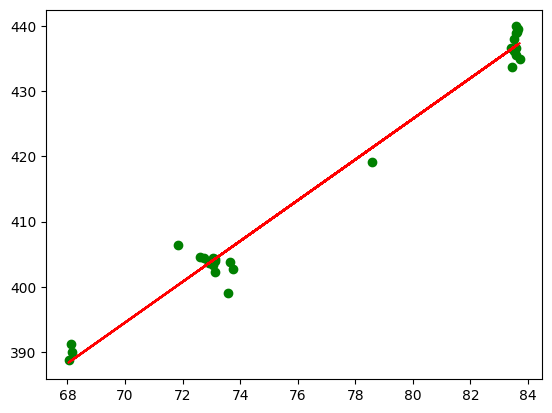

In [64]:
# Визуализация полученных результатов
plt.scatter(X_test, Y_test, color="green")
plt.plot(X_test, Y_predicted, color="red")

# Оценка качества модели

In [65]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_predicted))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_predicted))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_predicted)))
print('R2 Score:', metrics.r2_score(Y_test, Y_predicted))

Mean Absolute Error: 1.7366537910281612
Mean Squared Error: 5.634384732612227
Root Mean Squared Error: 2.3736858959458447
R2 Score: 0.9821951822723708


# Новая линейная регрессия

Рассмотрим настройку линейной регрессии с учётом значимости признаков модели.
Изначально включили в модель все признаки, в последствие исключали признаки по самому высокому показателю P-value. 
В итоге осталось два признака: OIL_RATE и U_BC.

In [66]:
df.columns

Index(['LIQ_RATE', 'OIL_RATE', 'WATER_CUT', 'PLIN', 'QGAS', 'FREQ_HZ',
       'ACTIV_POWER', 'PINP', 'I_B', 'I_A', 'I_C', 'U_AB', 'U_BC', 'U_CA',
       'COS_PHI'],
      dtype='object')

In [67]:
X = df[['OIL_RATE', 'U_BC']]
Y = df['LIQ_RATE']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [68]:
model = sm.OLS(Y_train, X_train)
results = model.fit()


In [69]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               LIQ_RATE   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          3.128e+06
Date:                Sat, 20 May 2023   Prob (F-statistic):                   1.89e-137
Time:                        03:10:52   Log-Likelihood:                         -91.114
No. Observations:                  56   AIC:                                      186.2
Df Residuals:                      54   BIC:                                      190.3
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
OIL_RATE       8.5210      0.072    118.440      0.000       8.377       8.665
U_BC           0.0713      0.008      8.615      0.000       0.055       0.088
==============================================================================
Omnibus:                       25.838   Durbin-Watson:                   1.779
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.766
Skew:                           1.460   Prob(JB):                     2.57e-11
Kurtosis:                       6.518   Cond. No.                         173.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
Y_predicted = results.predict(X_test)

In [71]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_predicted))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_predicted))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_predicted)))
print('R2 Score:', metrics.r2_score(Y_test, Y_predicted))

Mean Absolute Error: 0.659454651151889
Mean Squared Error: 1.1423596656287007
Root Mean Squared Error: 1.068812268655586
R2 Score: 0.9963901106170141


# RandomForestRegressor


Далее использовали модель случайного леса. Она показала значение метрики ниже, чем линейная регрессия.

In [72]:
model = RandomForestRegressor()
model.fit(X_train, Y_train)

Y_predicted = model.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_predicted))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_predicted))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_predicted)))
print('R2 Score:', metrics.r2_score(Y_test, Y_predicted))

Mean Absolute Error: 0.7511143678160951
Mean Squared Error: 1.5849285531705084
Root Mean Squared Error: 1.2589394557207698
R2 Score: 0.9949915802097822


# CatBoost

Пляски с CatBoost'ом не привели к улучшению метрики по сравнению с линейной регрессией. 

In [73]:
model = CatBoostRegressor()
model.fit(X_train, Y_train, verbose=False)

Y_predicted = model.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_predicted))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_predicted))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_predicted)))
print('R2 Score:', metrics.r2_score(Y_test, Y_predicted))

Mean Absolute Error: 1.4641232936212458
Mean Squared Error: 4.574022317221521
Root Mean Squared Error: 2.138696406043065
R2 Score: 0.9855459579874163


**Общий вывод**

Наилучший результат показала линейная регрессия с наилучшим значением метрики R2: 0.99639. 